In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

C.1 (non-coding). 

As long as S(0)> 0, the exponential nature of 2.2 ensures that Sn > 0 for all n, so predictions are realistic/sensible. 

In contrast, in 2.1, Sn may become negative if Δt or σSnΔWn are too large (this is unlikely as there's limited liability of stocks, but still worth considering). In real life, stock returns have a multiplicative nature, for which an exponential model such as C2.2 is most suitable. Further, C2.2 is derived from exact solution to the SDE whereas C2.1 is approximation which is more likely to have larger errors over time.

C.2. (below):

 I define function simulate_gbm using the information given, that simulates P paths of stock prices over T years, returns matrix with one row per path, one column per time step (T/N). I then sum the log returns over time intervals, insert a zero column to ensure at t=0 the value is S_0, then exponentiate the sum to return final pension values for all paths. Note that I hard code the volatlility (σ = 0.15) and initial stock price (S_0 = 1) as instructed.

In [11]:
def simulate_gbm(mu, P, T, N):
    sigma = 0.15
    S_0 = 1
    dt = T/N
    delta_W = np.random.normal(loc=0, scale=np.sqrt(dt), size=(P, N))
    powers = (mu - 0.5*(sigma**2))*dt + sigma*delta_W
    cumul_powers = np.cumsum(powers, axis = 1)
    cumul_powers = np.insert(cumul_powers, 0, 0, axis=1) 
    S = S_0*np.exp(cumul_powers)
    return S

#Check that the matrix produced is actually (P x (N+1)) by substituting P = 10, N=3. 

print(f"{simulate_gbm(0.05, 10, 40, 3).shape}")

#Output is a 10x4 matrix as expected.

(10, 4)


C.3. (below):

I use the defined function to simulate 100 000 paths over 40 years with monthly steps. I then plot samples, mean, percentiles on a single plot, using different colours and a key to make the plot visually appealing. The mean and percentiles I found using np.mean and np.percentile respectively. Note the time vector has 481 (=N+1) points to include the initial time.

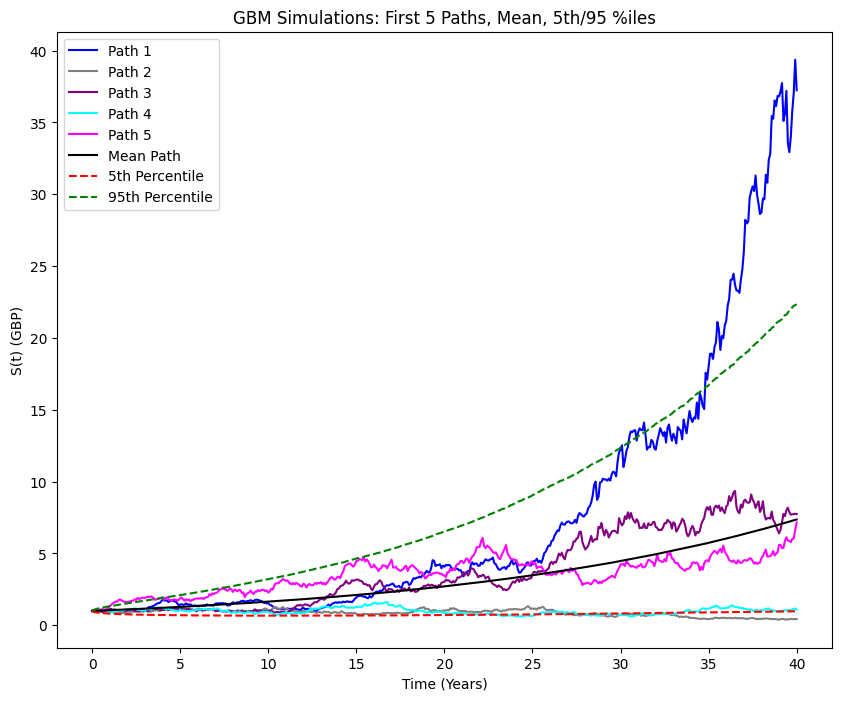

In [12]:

S = simulate_gbm(0.05, 100000, 40, 480)
time=np.linspace(0, 40, 481) 
plt.figure(figsize=(10, 8))
colors = ['blue', 'grey', 'purple', 'cyan', 'magenta']
for i in range(5):
    plt.plot(time, S[i], color=colors[i], label=f'Path {i+1}')
mean_path = np.mean(S, axis=0)
plt.plot(time, mean_path, color='black', label='Mean Path')
plt.plot(time, np.percentile(S, 5, axis=0), '--', color='red', label='5th Percentile')
plt.plot(time, np.percentile(S, 95, axis=0), '--', color='green', label='95th Percentile')
plt.xlabel('Time (Years)')
plt.ylabel('S(t) (GBP)')
plt.title('GBM Simulations: First 5 Paths, Mean, 5th/95 %iles')
plt.legend()
plt.show()

C.4. (below):

 I define a function that calculates the final pension value via the following steps:
 For each path/simulation, calc ratios: final investment value/value at month i for every i <= 12T.
 Then, sum ratios to give the total growth multiplier and muiltiply by investment/month to estimate the final pension value. 
 I then went on to check that the function gave the correct value for 2 simple examples.

In [13]:
def pension_value(paths, T, M):
    ratios = (paths[:, -1]).reshape(-1, 1) / paths[:, :12*T]  
    sum_ratios = np.sum(ratios, axis=1)  
    return M * sum_ratios

#Test1: 12 months (T=1), £100 per month (M=100), stock price remains stable (paths = matrix of 1s)

print(pension_value(np.ones((1, 13)), 1, 100))

#Test returned £1200 as expected.

#Test2: 24 months (T=2), £10 per month (M=100), stock price remains stable until doubles in last 
# month (paths = matrix of 1s with 2s in last column)

paths2 = np.ones((1, 25))
paths2[:, -1] = 2
print(pension_value(paths2, 2, 10))

#Test returned £480 as expected

[1200.]
[480.]



C.5. (below):

In this section I find final pension value (V) of all paths when the monthly investment is £1000. Note, I divided this value by 1x10^6 so I could work in £ millions. I then separate the paths into bins (width £50 000) based on final value, and plot a histogram displaying the count of paths/simulations per bin. I found the value bin with highest count by using the argmax function, and displayed and labelled it on my plot. I chose to use a log scale for the y-axis to make visible the distribution at the upper end of the x axis (higher value bins, with smaller counts).

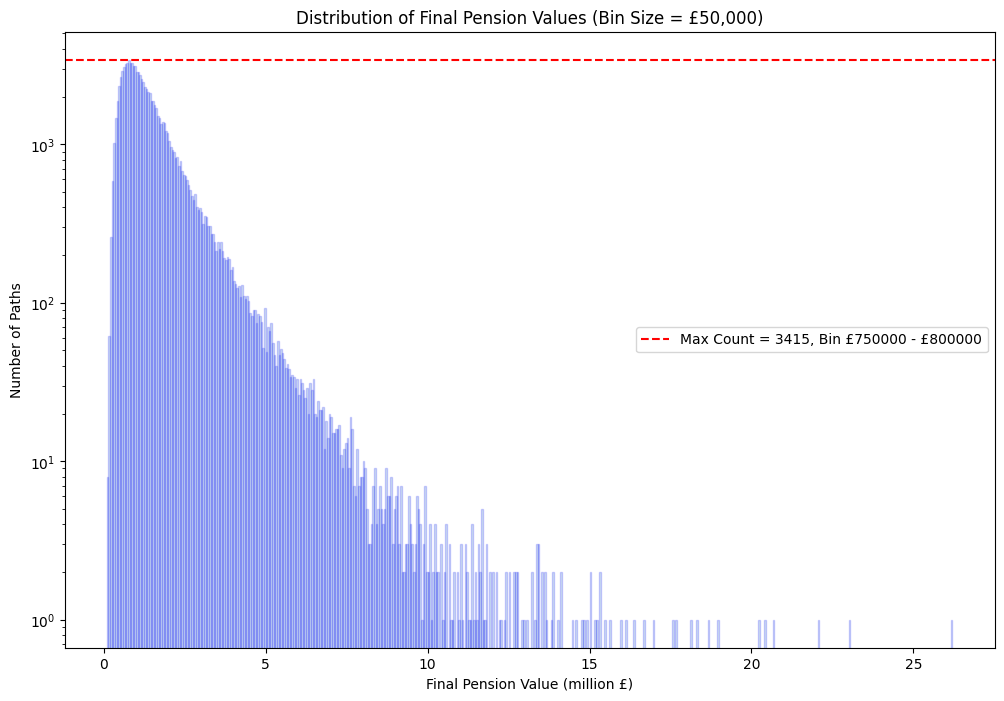

Bin with the highest count is Bin £750000 - £800000 as shown in figure.


In [14]:

V = (pension_value(S, 40, 1000))/1e6 
minV = np.floor(V.min()/0.05)*0.05
maxV = np.ceil(V.max()/0.05)*0.05
bins = np.arange(minV, maxV+0.05, 0.05)

plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(V, bins=bins, edgecolor='blue', alpha=0.2)
maxcount = np.argmax(n)
LB = (1e6)*bins[maxcount]
UB = (1e6)*bins[maxcount + 1]
plt.axhline(y=n[maxcount], color='red', linestyle='--', label=f'Max Count = {n[maxcount]:.0f}, Bin £{LB:.0f} - £{UB:.0f}')
plt.xlabel('Final Pension Value (million £)')
plt.ylabel('Number of Paths')
plt.yscale('log') 
plt.title(f'Distribution of Final Pension Values (Bin Size = £50,000)')
plt.legend()
plt.show()

print(f"Bin with the highest count is Bin £{LB:.0f} - £{UB:.0f} as shown in figure.")

#C.6 (non-coding). 

S_0 represents the initial stock price. If we think about S_0 doubling in value, but an investor still investing the same monthly amount, they will buy half the number of stocks each month. Then this initial investment will grow multiplicatively in the same way/by the same growth factor it orginally would've done, so we see that the final pension value would be unchanged. Therefore we can conclude that the final value of the pension is independent of the original stock price.


C.7. (below):

 I use the np.mean function to find the observed probability of the final pension value, V, being less than the total invested amount (£0.48mil), at least double the invested amount (exceeding £9.8mil), and the value being at least £2mil. (Note that the reason why the total invested amount is £480 000 = £0.48mil is that we are still considering M = 1000). I chose to express the probabilities as percentages rounded to 2 decimal places.



In [15]:
obs_p_loss = np.mean(V < 0.48)
print(f"Probability of loss: {obs_p_loss * 100:.2f}%")
obs_p_double = np.mean(V >= 0.96)
print(f"Probability of doubling: {obs_p_double * 100:.2f}%")
obs_p_2mil = np.mean(V >= 2)
print(f"Probability of V ≥ £2,000,000: {obs_p_2mil * 100:.2f}%")

Probability of loss: 6.70%
Probability of doubling: 63.57%
Probability of V ≥ £2,000,000: 22.16%


C.8. (below):
 I define a function R to estimate the probability of reaching a final value of £1mil over 40 years for different monthly investments M and growth rates μ. It simulates 100 000 paths for the given value of μ and extracts the final column to get a vector that represents the final values of the pensions, then computing all ratios (final/monthly) at once. Similarly to the pension_value function, it then sums the ratios and multiplies by the monthly investment(s) to find the final value, then uses np.mean to estimate probability of exceeding 1 million. I plotted these probabilities on a graph. 
 
 I then define S_0i = simulations of stock prices for growth rate i%. The function comf_retire_prob is very similar to R, but is more efficient as it calculates the probability for a fixed (precomputed) S.
 
 The functions (h_0i) represent the difference between 95% and the observed probability, so the root of these functions will be the minimum required investment to reach 95% probability of comfortable retirement. I found the root by introducing a python iterative rootfinding function (brentq), found during research. I set the tolerance to 0.005 to ensure the function found the root to the correct penny, but I could increase the speed at which my program runs by increasing this tolerance slightly.

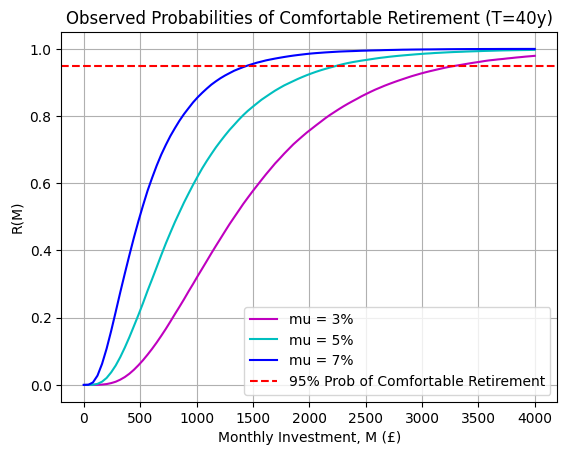

Min. required monthly investment over 40y for 95% probability of comfortable retirement (μ = 7%): £1449.07
Min. required monthly investment over 40y for 95% probability of comfortable retirement (μ = 5%): £2233.91
Min. required monthly investment over 40y for 95% probability of comfortable retirement (μ = 3%): £3303.75


In [16]:
Ms = np.linspace(0, 4000, 100)
def R(mu, Ms):
    S = simulate_gbm(mu, 100000, 40, 480)
    S_final = S[:, -1]  
    ratios = S_final.reshape(-1, 1) / S[:, :480]  
    ratiosum = np.sum(ratios, axis=1)  
    V = (Ms.reshape(-1,1))*ratiosum / 1e6
    return np.mean(V >= 1, axis=1) 

plt.grid()
plt.plot(Ms, R(0.03, Ms), 'm', label='mu = 3%')
plt.plot(Ms, R(0.05, Ms), 'c', label='mu = 5%')
plt.plot(Ms, R(0.07, Ms), 'b', label='mu = 7%')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Prob of Comfortable Retirement')
plt.ylabel('R(M)')
plt.xlabel('Monthly Investment, M (£)')
plt.title('Observed Probabilities of Comfortable Retirement (T=40y)')
plt.legend()
plt.show()

S_07 = simulate_gbm(0.07, 100000, 40, 480)
S_05 = simulate_gbm(0.05, 100000, 40, 480)
S_03 = simulate_gbm(0.03, 100000, 40, 480)
def comf_retire_prob(S, Ms, Nmonths):
    ratios = (S[:, -1]).reshape(-1,1) / S[:, :Nmonths] 
    V = Ms.reshape(-1,1) * np.sum(ratios, axis=1) / 1e6 
    return np.mean(V >= 1, axis=1) 
def h_07(M):
    return 0.95 - comf_retire_prob(S_07, np.array([M]), 480)[0]
def h_05(M):
    return 0.95 - comf_retire_prob(S_05, np.array([M]), 480)[0]
def h_03(M):
    return 0.95 - comf_retire_prob(S_03, np.array([M]), 480)[0]
M_07 = brentq(h_07, 1300, 1600, xtol=5e-3)
M_05 = brentq(h_05, 2100, 2400, xtol=5e-3)
M_03 = brentq(h_03, 3200, 3500, xtol=5e-3)
print(f"Min. required monthly investment over 40y for 95% probability of comfortable retirement (μ = 7%): £{M_07:.2f}")
print(f"Min. required monthly investment over 40y for 95% probability of comfortable retirement (μ = 5%): £{M_05:.2f}")
print(f"Min. required monthly investment over 40y for 95% probability of comfortable retirement (μ = 3%): £{M_03:.2f}")

The graph above shows that the probability of comfortable retirement increases with the monthly investment as expected. The increase is not linear, instead the graph forms a sigmoidal shape. This is because it is plotting probability, so when M is very low/very high respectively, almost none/all of the paths reach £1mil, so the curve is flatter near probabilities 0 and 1. Inbetween, each small increase in M causes exponential growth in the final value due to the nature of compounding, causing a steep slope.

The graph displays very similar shapes for the different growth rates, but it is clear that, particularly for the lower monthly investments, probability of comfortable retirement is significantly higher when growth rate is higher. This is what we would logically expect.

C.9. (below):

I define functions very similar to those in section C.8 above but now for a 20 year time period (so T=20, N=240). I found that defining functions and precomputing simulations for 20/40 years separately made my code run more quickly, which is why I've done it this way rather than creating an R function that worked for both. Again, I used the rootfinding function brentq to estimate the minimum monthly required investment.

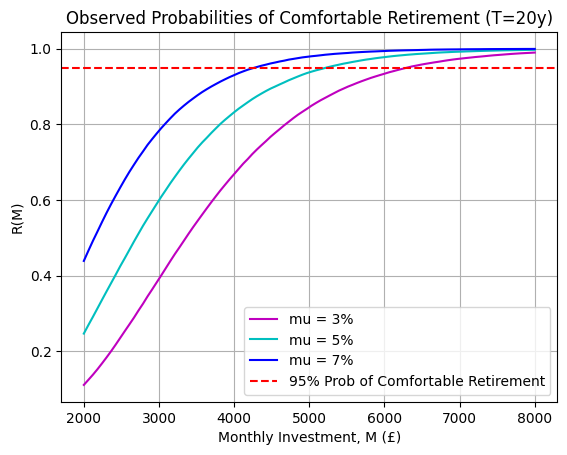

Min. required monthly investment over 20y for 95% probability of comfortable retirement (μ = 7%): £4265.98
Min. required monthly investment over 20y for 95% probability of comfortable retirement (μ = 5%): £5201.49
Min. required monthly investment over 20y for 95% probability of comfortable retirement (μ = 3%): £6303.95


In [17]:

M1s = np.linspace(2000, 8000, 100)
def R1(mu, M1s):
    S1 = simulate_gbm(mu, 100000, 20, 240)
    S1_final = S1[:, -1]  
    ratios1 = S1_final.reshape(-1, 1) / S1[:, :240] 
    ratiosum1 = np.sum(ratios1, axis=1)  
    V1 = (M1s.reshape(-1,1))*ratiosum1 / 1e6
    return np.mean(V1 >= 1, axis=1) 

plt.grid()
plt.plot(M1s, R1(0.03, M1s), 'm', label='mu = 3%')
plt.plot(M1s, R1(0.05, M1s), 'c', label='mu = 5%')
plt.plot(M1s, R1(0.07, M1s), 'b', label='mu = 7%')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Prob of Comfortable Retirement')
plt.ylabel('R(M)')
plt.xlabel('Monthly Investment, M (£)')
plt.title('Observed Probabilities of Comfortable Retirement (T=20y)')
plt.legend()
plt.show()

S1_07 = simulate_gbm(0.07, 100000, 20, 240)
S1_05 = simulate_gbm(0.05, 100000, 20, 240)
S1_03 = simulate_gbm(0.03, 100000, 20, 240)
def h1_07(M):
    return 0.95 - comf_retire_prob(S1_07, np.array([M]), 240)[0]
def h1_05(M):
    return 0.95 - comf_retire_prob(S1_05, np.array([M]), 240)[0]
def h1_03(M):
    return 0.95 - comf_retire_prob(S1_03, np.array([M]), 240)[0]
M1_07 = brentq(h1_07, 4100, 4400, xtol=5e-3)
M1_05 = brentq(h1_05, 5000, 5300, xtol=5e-3)
M1_03 = brentq(h1_03, 6100, 6400, xtol=5e-3)

print(f"Min. required monthly investment over 20y for 95% probability of comfortable retirement (μ = 7%): £{M1_07:.2f}")
print(f"Min. required monthly investment over 20y for 95% probability of comfortable retirement (μ = 5%): £{M1_05:.2f}")
print(f"Min. required monthly investment over 20y for 95% probability of comfortable retirement (μ = 3%): £{M1_03:.2f}")

The graph above for a time period of 20 years is similar to that for 40 years, but we see that higher monthly investments are required to reach the same probabilities of comfortable retirement. This is as expected, since if there are half the number singular investments made, each one must be larger. 

Also, compound interest has less of a positive impact over a shorter time period. I chose to only include a range of £2000 to £8000 on my plot for the monthly investments since it makes the shape more visible around the 95% region.


Final comments on C.8 and C.9 (How much larger M must be when T=20 rather than 40):

For higher μ values, shortening the investment period to 20 years results in a greater increase in the required monthly investment. For μ=7%, μ=5%, respectively, the required M for T=20 is almost 3x, and almost 2.5x the required M for T=40. These observations are due to higher expected returns increasing the power of compounding over time, so investing over a 2x longer period is very beneficial. 

In contrast, for μ=3%, the required M for T=20 is only 1.9x the required M for T=40. This seems unintuitive, as it contradicts the familiar idea that investing over a longer time period is better. However, I realised that when the rate of return is low, the high volatility (15%) may be the issue. In order to test this hypothesis, I ran my code with the volatility at only 5%. In this case, for every μ, the required M for T=40 was less than half that for T=20, so even for low rates of return, investing over a longer period is safer. This suggested to me that it wasn't an issue with my code, and supports the idea that, when there is very high volatility, investing over a longer period is not necessarily safer (especially when rate of return is low).